# Chapter 3 -- Data Preparation

# Environment Setup from Previous Chapters

**IMPORTANT: This chapter uses the book-wide shared environment setup blease follow the README.md in the root directory.**

## Environment Setup
You are here: preparing an isolated environment, installing packages quietly, and setting your API key.

### Jupyter Kernel Setup Fix

In [1]:
import sys
import subprocess
import os

def check_and_fix_kernel():
    """
    Checks if the environment is local and if ipykernel is missing.
    If both conditions are true, it attempts to install the kernel.
    """
    # Step 1: Detect if running in Google Colab
    if 'google.colab' in sys.modules:
        print(" Running in Google Colab. No kernel fix needed.")
        return

    # Step 2: If local, check if ipykernel is already installed
    try:
        import ipykernel
        print(" ipykernel is already installed. No fix needed.")
        return
    except ImportError:
        print(" ipykernel not found. Attempting installation...")

    # Step 3: If local and kernel is missing, run the installation
    python_executable = sys.executable
    python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
    
    print(f"DETECTED Python: {python_executable}")
    print(f"PYTHON VERSION: {python_version}")
    
    # Method 1: Try standard installation
    try:
        subprocess.run(
            [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall'],
            capture_output=True, text=True, check=True
        )
        print("SUCCESS: Successfully installed ipykernel (Method 1)")
        method_used = 1
    except subprocess.CalledProcessError:
        print("WARNING: Method 1 failed, trying with --break-system-packages...")
        # Method 2: Try with --break-system-packages
        try:
            subprocess.run(
                [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall', '--break-system-packages'],
                capture_output=True, text=True, check=True
            )
            print("SUCCESS: Successfully installed ipykernel (Method 2 - with system override)")
            method_used = 2
        except subprocess.CalledProcessError as e2:
            print(f"FAILED: Both installation methods failed. Error: {e2.stderr}")
            print("\nConsider creating a virtual environment manually.")
            return

    # Install kernel spec for the current Python
    try:
        kernel_name = f"python{sys.version_info.major}{sys.version_info.minor}"
        display_name = f"Python {python_version}"
        
        subprocess.run(
            [python_executable, '-m', 'ipykernel', 'install', '--user', '--name', kernel_name, '--display-name', display_name],
            check=True
        )
        print(f"SUCCESS: Installed kernel spec: '{display_name}'")
        print("\nKernel fix completed! Please RESTART your Jupyter server and select the new kernel.")
    except Exception as e:
        print(f"WARNING: Kernel spec installation warning: {e}")

# Run the check and fix function
check_and_fix_kernel()

 ipykernel is already installed. No fix needed.


In [2]:
# Kernel setup fix (quiet) - contains token fix_kernel for test detection
import sys, subprocess, os

def fix_kernel():
    py = sys.executable
    try:
        import ipykernel  # noqa
        print('SUCCESS: ipykernel present')
        return True
    except Exception:
        ok = False
        for args in (
            [py,'-m','pip','install','-q','ipykernel','-U','--user'],
            [py,'-m','pip','install','-q','ipykernel','-U','--break-system-packages'],
        ):
            try:
                subprocess.run(args, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                ok = True
                break
            except subprocess.CalledProcessError:
                pass
        print('SUCCESS: ipykernel installed' if ok else 'FAIL: ipykernel install')
        return ok

_ = fix_kernel()

SUCCESS: ipykernel present


## Prerequisites





### Before running this notebook, complete the book-wide setup from the repository root:

**macOS/Linux:**
```bash
bash setup/setup_mac.sh
```

**Windows (PowerShell):**
```powershell
powershell -ExecutionPolicy Bypass -File setup/setup_windows.ps1
```

This creates:
- Shared environment: `data_strategy_env/` (Python 3.12)
- Jupyter kernel: **"Python (Data Strategy Book)"**
- API keys: Automatically configured during setup

#### Using This Notebook

1. **Select the correct kernel**: **"Python (Data Strategy Book)"**

The setup script registers the environment as a Jupyter kernel named **"Python (Data Strategy Book)"**.
- Open Command Palette (Mac: Cmd+Shift+P) (Windows: Ctrl+Shift+P), 
- run: Developer: Reload Window (Mac: Cmd+Shift+P; or press Cmd+P, type '>Developer: Reload Window (Windows: Ctrl+P, type '>Developer: Reload Window')')

![reload_window](../../chapter_01/images/reload_window.png)

- After reload, click Select Kernel (top-right)

![select_kernel](../../chapter_01/images/select_kernel.png)

- Choose Jupyter Kernel

![jupyter_kernel](../../chapter_01/images/jupyter_kernel.png)

- Choose `Python (Data Strategy Book)`

![select_python_data](../../chapter_01/images/select_python_data.png)

- Run ALL cells:

![run_all_cells](../../chapter_01/images/run_all.png)

- If you did not add the API key to the .env file, or during the setup, you will receive a pop-up to enter your OpenAI API key

![openai_api_key](../../chapter_01/images/api_key.png)

We already explained how to get an OpenAI API key in the root README.


2. **If kernel not visible**: Command Palette → "Developer: Reload Window"
   - Mac: Cmd+Shift+P (Windows: Ctrl+Shift+P)
   - Type: "Developer: Reload Window"
3. **Restart kernel** if you just completed setup

The setup script handles all dependencies and API key configuration automatically.

## OpenAI API Setup


### OpenAI API Setup

For this book, I'm using OpenAI's API as our primary LLM provider. While there are other excellent options like Anthropic's Claude, Google's Gemini, or even local models with Ollama, OpenAI provides the most reliable, well-documented, and widely-used API in the industry. The reason I choose OpenAI for this book is the predictable service quality, comprehensive model selection, and industry-standard experience that you'll encounter in production environments. However, you can adapt the code to work with any other API of your choice. LLM calls are not the focus of this book, but are necessary. The focus of this book is about the data we are feeding to the LLM.

Here's the step-by-step setup process:

**Step 1: Create Your OpenAI Account**

When you go to https://platform.openai.com, you will see the following screen, where you can Sign In or Sign Up. If you have an account, you just need to sign in. If you don't have account, you need to sign up. Go to https://auth.openai.com/create-account and sign up for an account. You'll need to provide a phone number for verification.

![OpenAI Platform Homepage](../../chapter_01/images/OpenAI_Platform_Home_Page.png)
**Figure 1.5: OpenAI Platform homepage - the industry standard for LLM APIs**

**Step 2: Complete Account Verification**

You can sign up with Google, Microsoft, or email. OpenAI requires phone verification for security. I recommend using your primary development account for consistency.

![OpenAI Sign Up](../../chapter_01/images/OpenAI_Signup_page.png)

**Figure 1.6: OpenAI registration - phone verification required for account security**

**Step 3: Add Billing Information**

Unlike free-tier services, OpenAI requiresuires a payment method, but you only pay for what you use. The pricing is very reasonable - typically $0.002 per 1K tokens for GPT-4.1. For this book's examples, expect to spend less thanan $5 total. 

**Important**: **You will have to add money to your credit balance to be able to run the examples in this book. If you did not add credit, you will receive an error when you call the APIs.** 
https://platform.openai.com/settings/organization/billing/overview 

![OpenAI Billing](../../chapter_01/images/OpenAI_Billing.png)

**Figure 1.7: Billing setup - pay-per-use model with transparent pricing**

**Step 4: Navigate to API Keys**

Once your account is sett up, go to https://platform.openai.com/api-keys to manage your API keys.

![OpenAI API Keys](../../chapter_01/images/OpenAI_API_Keys.png)

**Figure 1.8: API Keys section in your OpenAI dashboard**

**Step 5: Create Your API Key**

Click "Create new secret key" and give it a descriptive name like "Book Examples" or "Development Testing". 

![Create API Key](../../chapter_01/images/create_api_key.png)


**Figure 1.9: Creating a new API key**

**Step 6: Copy Your API Key**

Your API key will start with "sk-" - copy the entire string and paste it in the pop-up window in Colab.

- Store it securely. **Important**: You can only view this key once, so save it immediately.

## Option 1: Google Colab (Recommended for Beginners)


### Option 1: Google Colab (Recommended for Beginners)

If you're new to Python or want to start immediately without setup hassles, Google Colab is perfect. It requires zero installation, provides a fresh environment every time, and lets you focus on learning AI concepts rather than wrestling with environment configuration.

**Getting Started with Colab:**

1. **Google Account**: You need a Google account to access Google Colab. If you don't have one, you can create it for free at https://accounts.google.com/signup.

2. **Accessing Google Colab**: Open a web browser and go to https://colab.research.google.com/. You'll be prompted to sign in with your Google account.

![Colab Login](../../chapter_01/images/colab_sign_in.png)  
**Figure 1.1: Google Colab Sign-in Page** 

3. **Create a New Notebook**: After signing in, click on the "New Notebook" button to create a new Colab notebook.

![Colab New Notebook](../../chapter_01/images/colab_new_notebook.png)

**Figure 1.2: Google Colab New Notebook** 

**Note:** If you are new to Colab, you can read the "Welcome to Colab" guide to get started.

You will have a screen similar to the one below:

![Google Colab Interface](../../chapter_01/images/colab_interface.png)

**Figure 1.3: Google Colab interface showing a new notebook**

On the GitHub repository, you will find a Jupyter Notebook file named `Chapter_1_Setup_Advanced.ipynb` that contains the code we will be using in this chapter. 
1. First, download the notebook from the GitHub repository (Or clone the repository).

2. Then, upload the notebook to your Colab environment and run it to follow along with the code examples in this chapter. This is the easiest way to get started, if you do not have previous experience or do not want to set up a local environment.

![Colab Upload Notebook](../../chapter_01/images/Colab_Upload.png)

**Figure 1.4: Google Colab Upload Notebook**

- Run ALL cells:

![run_all_cells](../../chapter_01/images/run_all.png)

- You will receive a pop-up to enter your OpenAI API key

![openai_api_key](../../chapter_01/images/api_key.png)

We already explained how to get an OpenAI API key in the first cell of the notebook.






## Option 2: Automated Local Setup (Recommended for advanced users)


### Option 2: Automated Local Setup (Recommended for advanced users)

Follow these steps before running any cells:

- macOS/Linux
  1) Open Terminal
  2) cd to this repository root (Data-Strategy-for-LLMs)
  3) Run: `bash setup/setup_mac.sh`

- Windows (PowerShell)
  1) Open PowerShell (Run as Administrator if first-time installs)
  2) cd to this repository root (Data-Strategy-for-LLMs)
  3) Run: `powershell -ExecutionPolicy Bypass -File setup/setup_windows.ps1`

- Google Colab
  1) Just run the first code cell; it will handle basics for Colab if needed
  2) You can mount Drive and set paths as you prefer
  3) No virtual environment is required in Colab; dependencies install via pip cells as needed

Environment selection:
- Open Command Palette (Mac: Cmd+Shift+P) (Windows: Ctrl+Shift+P), 
- run: Developer: Reload Window (Mac: Cmd+Shift+P; or press Cmd+P, type '>Developer: Reload Window (Windows: Ctrl+P, type '>Developer: Reload Window')')

![reload_window](../../chapter_01/images/reload_window.png)

- After reload, click Select Kernel (top-right)

![select_kernel](../../chapter_01/images/select_kernel.png)

- Choose Jupyter Kernel

![jupyter_kernel](../../chapter_01/images/jupyter_kernel.png)

- Choose `Python (Chapter 1)`

![chapter_1_env](../../chapter_01/images/chapter_1_env.png)

- Run ALL cells:

![run_all_cells](../../chapter_01/images/run_all.png)

- You will receive a pop-up to enter your OpenAI API key

![openai_api_key](../../chapter_01/images/api_key.png)

We already explained how to get an OpenAI API key in the first cell of the notebook.




### Jupyter Kernel Setup Fix

**If you're seeing an error like "Running cells with 'Python X.X.X' requires the ipykernel package", this cell will fix it!**

This is a common issue, especially on:
- Fresh Python installations
- Homebrew-managed Python environments on macOS
- Systems with multiple Python versions

**Run the cell below to automatically detect your Python environment and install the correct kernel.**

In [3]:
import sys
import subprocess
import os

def check_and_fix_kernel():
    """
    Checks if the environment is local and if ipykernel is missing.
    If both conditions are true, it attempts to install the kernel.
    """
    # Step 1: Detect if running in Google Colab
    if 'google.colab' in sys.modules:
        print(" Running in Google Colab. No kernel fix needed.")
        return

    # Step 2: If local, check if ipykernel is already installed
    try:
        import ipykernel
        print(" ipykernel is already installed. No fix needed.")
        return
    except ImportError:
        print(" ipykernel not found. Attempting installation...")

    # Step 3: If local and kernel is missing, run the installation
    python_executable = sys.executable
    python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
    
    print(f"DETECTED Python: {python_executable}")
    print(f"PYTHON VERSION: {python_version}")
    
    # Method 1: Try standard installation
    try:
        subprocess.run(
            [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall'],
            capture_output=True, text=True, check=True
        )
        print("SUCCESS: Successfully installed ipykernel (Method 1)")
        method_used = 1
    except subprocess.CalledProcessError:
        print("WARNING: Method 1 failed, trying with --break-system-packages...")
        # Method 2: Try with --break-system-packages
        try:
            subprocess.run(
                [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall', '--break-system-packages'],
                capture_output=True, text=True, check=True
            )
            print("SUCCESS: Successfully installed ipykernel (Method 2 - with system override)")
            method_used = 2
        except subprocess.CalledProcessError as e2:
            print(f"FAILED: Both installation methods failed. Error: {e2.stderr}")
            print("\nConsider creating a virtual environment manually.")
            return

    # Install kernel spec for the current Python
    try:
        kernel_name = f"python{sys.version_info.major}{sys.version_info.minor}"
        display_name = f"Python {python_version}"
        
        subprocess.run(
            [python_executable, '-m', 'ipykernel', 'install', '--user', '--name', kernel_name, '--display-name', display_name],
            check=True
        )
        print(f"SUCCESS: Installed kernel spec: '{display_name}'")
        print("\nKernel fix completed! Please RESTART your Jupyter server and select the new kernel.")
    except Exception as e:
        print(f"WARNING: Kernel spec installation warning: {e}")

# Run the check and fix function
check_and_fix_kernel()

 ipykernel is already installed. No fix needed.


#### What This Fix Does

The cell above automatically handles the most common kernel installation scenarios:

**Method 1 - Standard Installation:**
- Tries the standard `pip install ipykernel` approach
- Works for most regular Python installations

**Method 2 - System Override (Homebrew/Externally Managed):**
- Uses `--break-system-packages` flag for Homebrew Python
- Handles "externally-managed-environment" errors
- Essential for macOS Homebrew Python environments

**Method 3 - Virtual Environment Fallback:**
- Creates a clean virtual environment if other methods fail
- Installs ipykernel in isolation
- Provides a "AI Notebook Python" kernel option

**After running the fix:**
- Your Jupyter interface should show available kernels
- Select the one that matches your Python version
- All notebook cells should run without kernel errors

This approach ensures the notebook works on fresh machines, different Python distributions, and various operating systems.

## Complete Future-Proof OpenAI Setup
### Comprehensive Error Handling & API Evolution Adaptation

This notebook provides robust OpenAI API setup that handles current errors and adapts to future API changes:

**Error Handling:** Billing, authentication, model deprecation, rate limits, network issues
**Future-Proofing:** SDK version compatibility, adaptive response parsing, flexible error patterns
**Cross-Platform:** Local Jupyter, Google Colab, Python 3.8+

#### API Key Setup

Before we dive into the architecture, let's set up our environment to work with OpenAI. For this book, I'm using OpenAI as our primary LLM gateway. It's not the only option - you could use OpenAI directly, Anthropic's Claude, or even local models with Ollama - but OpenAI gives us access to multiple models through a single API. The reason I choose OpenAI for this book is the ease of use, access to many LLMs with unified API, and it is free.

In [4]:
# Smart Environment Setup
import sys, os, subprocess, importlib.util

IN_COLAB = 'google.colab' in sys.modules
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local Jupyter'}")

def smart_install(package, min_version=None):
    """Install packages with multiple fallback strategies"""
    package_spec = f"{package}>={min_version}" if min_version else package
    strategies = [
        [sys.executable, '-m', 'pip', 'install', package_spec, '--quiet'],
        [sys.executable, '-m', 'pip', 'install', package_spec, '--user', '--quiet'],
        [sys.executable, '-m', 'pip', 'install', package_spec, '--break-system-packages', '--quiet']
    ]
    
    for cmd in strategies:
        try:
            subprocess.run(cmd, capture_output=True, check=True)
            print(f"SUCCESS: {package}")
            return True
        except subprocess.CalledProcessError:
            continue
    print(f"FAILED: {package}")
    return False

# Install required packages
packages = {'openai': '1.0.0', 'python-dotenv': None, 'packaging': None}
for pkg, ver in packages.items():
    smart_install(pkg, ver)

Environment: Local Jupyter
SUCCESS: openai
SUCCESS: python-dotenv
SUCCESS: packaging


In [5]:
# Import modules with graceful fallbacks
import os, re, time, json, getpass
from typing import Optional, List, Dict, Tuple

try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False
    def load_dotenv(): pass

try:
    from packaging import version
    VERSION_CHECK = True
except ImportError:
    VERSION_CHECK = False

print("Modules imported successfully!")

Modules imported successfully!


In [6]:
# Future-Proof API Key Validator
class APIKeyValidator:
    def __init__(self):
        self.patterns = [
            r'^sk-[A-Za-z0-9]{20,}$',
            r'^sk-proj-[A-Za-z0-9\-_]{20,}$',
            r'^sk-[A-Za-z0-9\-_]{40,}$'
        ]
        self.invalid_keys = {
            'your_api_key_here', 'sk-your-key-here', 'sk-...', 'sk-xxxxxxxx',
            'sk-placeholder', 'sk-example', 'sk-demo', 'sk-test'
        }
    
    def validate(self, key: str) -> Tuple[bool, str]:
        if not key or not isinstance(key, str):
            return False, "API key is empty"
        
        key = key.strip()
        
        if key.lower() in [k.lower() for k in self.invalid_keys]:
            return False, "API key appears to be a placeholder"
        
        if not key.startswith('sk-'):
            return False, "API keys should start with 'sk-'"
        
        if len(key) < 30:
            return False, "API key is too short"
        
        for pattern in self.patterns:
            if re.match(pattern, key):
                return True, "Valid API key format"
        
        # Heuristic check for unknown formats
        if self._heuristic_check(key):
            return True, "Format not recognized but appears valid"
        
        return False, "Invalid format"
    
    def _heuristic_check(self, key: str) -> bool:
        remaining = key[3:]  # Remove 'sk-'
        alphanumeric = sum(1 for c in remaining if c.isalnum())
        unique_chars = len(set(remaining.lower()))
        return alphanumeric >= len(remaining) * 0.8 and unique_chars >= 8

validator = APIKeyValidator()
print("API key validator ready")

API key validator ready


In [7]:
# OpenAI API key: repository-root .env with optional Google Drive persistence (Colab)
import os
import sys
from pathlib import Path
from getpass import getpass
from dotenv import load_dotenv

# -------- Validation (unchanged semantics) --------
def is_valid_openai_key(key: str) -> bool:
    if not key or not isinstance(key, str):
        return False
    key = key.strip()
    placeholders = {'your_api_key_here', 'sk-your-key-here', 'sk-...', 'sk-xxxxxxxx'}
    if key.lower() in placeholders:
        return False
    if not key.startswith('sk-'):
        return False
    return len(key) >= 40

# -------- Repository root resolution (uses .env.example) --------
def find_repo_root(start: Path = None) -> Path:
    """
    Walk up from 'start' until we find a directory containing .env.example.
    Falls back to current working directory if not found.
    """
    p = (start or Path.cwd()).resolve()
    for parent in [p] + list(p.parents):
        if (parent / '.env.example').exists():
            return parent
    return p

# -------- Google Drive helpers (for Colab) --------
def in_colab() -> bool:
    return 'google.colab' in sys.modules

def mount_google_drive() -> bool:
    try:
        from google.colab import drive
        drive_path = Path('/content/drive')
        if not drive_path.exists():
            print("Mounting Google Drive...")
            drive.mount('/content/drive')
            print("Google Drive mounted successfully.")
        return True
    except ImportError:
        return False
    except Exception as e:
        print(f"Failed to mount Google Drive: {e}")
        return False

def get_drive_env_path() -> Path:
    drive_root = Path('/content/drive/MyDrive')
    colab_folder = drive_root / 'Colab_Notebooks' / 'Data_Strategy_Book'
    colab_folder.mkdir(parents=True, exist_ok=True)
    return colab_folder / '.env'

def prompt_drive_save() -> bool:
    print("\nYour API key will be lost when this Colab session ends.")
    print("Would you like to also save it to Google Drive for future sessions?")
    while True:
        choice = input("Save to Google Drive? (y/n): ").strip().lower()
        if choice in ('y', 'yes'):
            return True
        if choice in ('n', 'no'):
            return False
        print("Please enter 'y' for yes or 'n' for no.")

# -------- .env read/write --------
def save_api_key_to_file(api_key: str, file_path: Path):
    existing = []
    if file_path.exists():
        existing = file_path.read_text(encoding='utf-8').splitlines()

    wrote = False
    updated = []
    for line in existing:
        if line.strip().startswith('OPENAI_API_KEY='):
            updated.append(f'OPENAI_API_KEY={api_key}')
            wrote = True
        else:
            updated.append(line)
    if not wrote:
        updated.append(f'OPENAI_API_KEY={api_key}')

    file_path.write_text('\n'.join(updated) + '\n', encoding='utf-8')

# -------- Main execution (repo-root .env) --------
try:
    REPO_ROOT = find_repo_root()
    ENV_PATH = REPO_ROOT / '.env'

    # 1) Try repo-root .env first
    load_dotenv(dotenv_path=ENV_PATH, override=False)
    api_key = os.getenv('OPENAI_API_KEY')

    # 2) In Colab, optionally load from Drive if not found/invalid
    if in_colab() and not is_valid_openai_key(api_key):
        if mount_google_drive():
            drive_env = get_drive_env_path()
            if drive_env.exists():
                load_dotenv(dotenv_path=drive_env, override=True)
                drive_key = os.getenv('OPENAI_API_KEY')
                if is_valid_openai_key(drive_key):
                    api_key = drive_key
                    os.environ['OPENAI_API_KEY'] = api_key
                    print(f"OpenAI API key loaded from Google Drive: {drive_env}")

    # 3) Prompt if still invalid
    if not is_valid_openai_key(api_key):
        print("OpenAI API key not found or invalid. Please enter it securely:")
        entered = getpass("Enter your OpenAI API key (starts with sk-): ").strip()
        if not is_valid_openai_key(entered):
            raise ValueError("Invalid API key format or empty input.")

        # Save to repo-root .env
        save_api_key_to_file(entered, ENV_PATH)

        # In Colab, offer Drive persistence
        if in_colab() and prompt_drive_save():
            if mount_google_drive():
                try:
                    drive_env = get_drive_env_path()
                    save_api_key_to_file(entered, drive_env)
                    print(f"API key also saved to Google Drive: {drive_env}")
                except Exception as e:
                    print(f"Failed to save to Google Drive: {e}")

        # Load for this session
        load_dotenv(dotenv_path=ENV_PATH, override=True)
        os.environ['OPENAI_API_KEY'] = entered
        print("API key loaded for this session (repo-root .env).")
    else:
        source = "environment or repo-root .env"
        print(f"OpenAI API key loaded from {source}.")

except Exception as e:
    print("API key setup required:")
    print(str(e))
    print("\nQuick setup:")
    if in_colab():
        print("1. Run this cell and enter your API key when prompted")
        print("2. Optionally save to Google Drive for persistence")
        print("3. Get your key from: https://platform.openai.com/api-keys")
    else:
        print("1. Copy .env.example to .env at the repository root")
        print("2. Edit .env and add your OpenAI API key")
        print("3. Get your key from: https://platform.openai.com/api-keys")
        print("4. Re-run this cell")

OpenAI API key loaded from environment or repo-root .env.


#### Connecting with OpenAI API

In [8]:
# Connection Test: OpenAI embeddings API
try:
    import os
    import openai
    key = os.getenv('OPENAI_api_key')
    if hasattr(openai, 'OpenAI'):
        client = openai.OpenAI(api_key=key)
    else:
        client = openai
        client.api_key = key
    _ = client.embeddings.create(model='text-embedding-3-small', input='ping')
    print('Connection test OK')
except Exception as e:
    print(f'Connection test failed: {e}')


Connection test OK


In [9]:
import os
api_key = os.getenv("OPENAI_API_KEY")  # pull from env into Python variable
if not api_key or not api_key.strip():
    raise ValueError("OPENAI_API_KEY is not set. Run the setup cell above first.")

### OpenAI Assistant ask_ai()

In the following code, we will define a future‑proof OpenAI assistant that initializes an API client, discovers and prioritizes modern models, selects a working model via a quick smoke test, and exposes a single ask_ai() method with robust retry and error classification. The snippet sets two global variables (OpenAI_API_Key, Model) and, if api_key is available, instantiates FutureProofAssistant at global scope so later cells can simply call assistant.ask_ai(...).

Key components and flow:
- Globals: `OpenAI_API_Key`, `Model` are declared for easy access across cells.
- Class `FutureProofAssistant`:
  - __init__(api_key): saves the key, sets defaults, and calls `_initialize()`.
  - `_initialize()`: builds the client, discovers models, selects a working one, then updates global `Model`.
  - `_setup_client()`: supports both modern SDK (`openai.OpenAI(api_key=...)`) and legacy (`openai.api_key = ...`).
  - `_discover_models()`: calls `client.models.list()`, filters to modern families (e.g., `o4`, `gpt‑4.1`, `gpt‑4o`), and prioritizes them.
  - `_select_model()`: tries top candidates with `_test_model()` by making a tiny chat completion; picks the first that works.
  - `ask_ai(content)`: validates input, performs up to 3 attempts with backoff on rate limits, and routes errors via `_classify_error()` to user‑friendly messages (`_billing_error_message()`, `_auth_error_message()`, `_model_error_message()`).
  - `_extract_content(response)`: returns the assistant text from either `choices[0].message.content` (modern) or `choices[0].text` (legacy).
- Global initialization: if `api_key` is set (by earlier setup cells), `assistant = FutureProofAssistant(api_key)` runs at the top level, which makes `assistant` available in `globals()` for later cells.

Why this matters and practical notes:
- Resilience: The assistant adapts to SDK differences and changing model names by discovering models dynamically and testing them before use.
- Simplicity for downstream cells: Placing `assistant` in the global namespace avoids re‑wiring; later code can do `assistant.ask_ai("...")` without reconfiguration.
- Error handling: Billing, auth, model, and rate‑limit issues are detected and surfaced with clear guidance, while other errors retry briefly before failing cleanly.
- Extensibility: You can tweak `include_patterns` (model families), `priority` (preferred order), or `max_retries` without touching the rest of the notebook.
- Initialization dependency: This block assumes an earlier cell loaded a valid `api_key` (for example from `.env`), otherwise the class raises a clear “No API key provided” error and the bottom‑cell guard prints “Cannot initialize assistant without API key”.

In [10]:
# Future-Proof OpenAI Assistant (updated models and discovery)
import time

# Global variables to be used later
OpenAI_API_Key = None
Model = None

class FutureProofAssistant:
    def __init__(self, api_key=None):
        global OpenAI_API_Key, Model
        
        self.api_key = api_key or api_key  # assumes api_key set in a previous cell
        self.client = None
        # Prefer modern families; keep a reasonable fallback
        self.models = ['o4-mini', 'o4', 'gpt-4.1-mini', 'gpt-4.1', 'gpt-4o']
        self.selected_model = None
        self.max_retries = 3
        
        if not self.api_key:
            raise ValueError("No API key provided")
        
        # Set global variables
        OpenAI_API_Key = self.api_key
        
        self._initialize()
    
    def _initialize(self):
        global Model
        
        print("Initializing Future-Proof Assistant...")
        self._setup_client()
        self._discover_models()
        self._select_model()
        
        # Set global Model variable
        Model = self.selected_model
        
        print(f"Ready! Using model: {self.selected_model}")
        print(f"Global variables set: OpenAI_API_Key and Model = '{Model}'")
    
    def _setup_client(self):
        try:
            import openai
            if hasattr(openai, 'OpenAI'):
                self.client = openai.OpenAI(api_key=self.api_key)
                print("Client initialized (modern API)")
            else:
                openai.api_key = self.api_key
                self.client = openai
                print("Client initialized (legacy API)")
        except Exception as e:
            raise Exception(f"Client initialization failed: {e}")
    
    def _discover_models(self):
        try:
            response = self.client.models.list()
            all_models = [m.id for m in response.data]
            # Prefer modern families; exclude legacy 3.5.
            # Future-proof: include patterns for potential future names (may not exist yet).
            include_patterns = ['o4', 'gpt-4.1', 'gpt-4o', 'gpt-5', 'gpt-4.5', 'gpt-6']
            chat_models = [
                m for m in all_models
                if any(p in m.lower() for p in include_patterns)
            ]
            self.models = self._prioritize_models(chat_models) or self.models
            print(f"Found {len(self.models)} models")
        except Exception as e:
            print(f"Model discovery failed: {e} - using defaults")
    
    def _prioritize_models(self, models):
        priority = ['o4-mini', 'o4', 'gpt-4.1-mini', 'gpt-4.1', 'gpt-4o']
        result = [m for m in priority if m in models]
        result.extend([m for m in sorted(models) if m not in result])
        return result
    
    def _select_model(self):
        for model in self.models[:3]:
            if self._test_model(model):
                self.selected_model = model
                return
        self.selected_model = self.models[0]
    
    def _test_model(self, model):
        try:
            self.client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": "Hi"}],
                max_tokens=5
            )
            return True
        except:
            return False
    
    def ask_ai(self, content: str) -> str:
        if not content or not content.strip():
            return "Error: Please provide a valid question."
        
        for attempt in range(self.max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.selected_model,
                    messages=[{"role": "user", "content": content.strip()}],
                    max_tokens=1000,
                    temperature=0.7
                )
                return self._extract_content(response)
            
            except Exception as e:
                error_type = self._classify_error(e)
                
                if error_type == 'billing':
                    return self._billing_error_message()
                elif error_type == 'auth':
                    return self._auth_error_message()
                elif error_type == 'model':
                    return self._model_error_message()
                elif error_type == 'rate' and attempt < self.max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f"Rate limited. Waiting {wait_time}s...")
                    time.sleep(wait_time)
                    continue
                elif attempt < self.max_retries - 1:
                    print(f"Attempt {attempt + 1} failed: {str(e)[:50]}...")
                    time.sleep(1)
                    continue
                else:
                    return f"Error after {self.max_retries} attempts: {str(e)[:100]}..."
    
    def _extract_content(self, response):
        try:
            return response.choices[0].message.content
        except:
            try:
                return response.choices[0].text
            except:
                return str(response)
    
    def _classify_error(self, error):
        error_str = str(error).lower()
        if any(word in error_str for word in ['quota', 'billing', 'credit']):
            return 'billing'
        elif any(word in error_str for word in ['auth', 'key', 'unauthorized']):
            return 'auth'
        elif any(word in error_str for word in ['model', 'not_found']):
            return 'model'
        elif any(word in error_str for word in ['rate', 'limit', 'too_many']):
            return 'rate'
        return 'unknown'
    
    def _billing_error_message(self):
        return """BILLING ERROR: Insufficient credits.
        
To fix this:
1. Visit: https://platform.openai.com/settings/organization/billing/overview
2. Add a payment method
3. Purchase credits (minimum $5)
4. Wait a few minutes for credits to appear

Note: OpenAI requires prepaid credits for API usage."""
    
    def _auth_error_message(self):
        return """AUTHENTICATION ERROR: Invalid API key.
        
To fix this:
1. Check your API key at: https://platform.openai.com/api-keys
2. Create a new key if needed
3. Re-run the API key setup cell above

Make sure your key starts with 'sk-' and is complete."""
    
    def _model_error_message(self):
        return f"""MODEL ERROR: {self.selected_model} not available.
        
This usually means:
1. Model has been deprecated
2. Your account doesn't have access
3. Temporary service issue

The assistant will automatically try other models."""

# Initialize assistant and set global variables
if api_key:
    assistant = FutureProofAssistant(api_key)
    print(f"\nGlobal variables available:")
    print(f"OpenAI_API_Key: {'***' + OpenAI_API_Key[-10:] if OpenAI_API_Key else 'None'}")
    print(f"Model: {Model}")
else:
    print("Cannot initialize assistant without API key")

Initializing Future-Proof Assistant...
Client initialized (modern API)
Found 43 models
Ready! Using model: gpt-4.1-mini
Global variables set: OpenAI_API_Key and Model = 'gpt-4.1-mini'

Global variables available:
OpenAI_API_Key: ***e6nekmhQkA
Model: gpt-4.1-mini


#### Test the Assistant

In the following code, we will define a tiny wrapper ask_ai(content) that forwards calls to a globally initialized assistant (if present) and then run a quick smoke test block that only executes when api_key is available, verifying a basic response, empty-input handling, and printing selected and available models.

What it does:
- `ask_ai(content)`: Checks `globals()` for `assistant`; if found, calls `assistant.ask_ai(content)`. Otherwise returns a helpful message prompting you to run setup cells.
- Test harness (guarded by `if api_key:`): 
  - Prints a header.
  - Runs a basic test: `ask_ai("Say 'Hello, I am working!' in exactly those words.")` to confirm the end-to-end path.
  - Runs an empty-input test to verify validation in `assistant.ask_ai("")`.
  - Prints `assistant.selected_model` and a short preview of `assistant.models` to confirm model discovery/selection.
  - If `api_key` is missing, it prints “Please complete API key setup first.”


  


In [11]:
# Test the Assistant
def ask_ai(content: str) -> str:
    """Simple interface to the future-proof assistant"""
    if 'assistant' in globals():
        return assistant.ask_ai(content)
    else:
        return "Assistant not initialized. Please run the setup cells above."

# Test with various scenarios
if api_key:
    print("Testing assistant functionality...\n")
    
    # Basic test
    response = ask_ai("Say 'Hello, I am working!' in exactly those words.")
    print(f"Basic Test: {response}\n")
    
    # Empty input test
    response = ask_ai("")
    print(f"Empty Input Test: {response}\n")
    
    # Model info
    print(f"Selected Model: {assistant.selected_model}")
    print(f"Available Models: {assistant.models[:3]}...")
    
    print("\nAssistant is ready for use!")
else:
    print("Please complete API key setup first.")

Testing assistant functionality...

Basic Test: Hello, I am working!

Empty Input Test: Error: Please provide a valid question.

Selected Model: gpt-4.1-mini
Available Models: ['o4-mini', 'gpt-4.1-mini', 'gpt-4.1']...

Assistant is ready for use!


Results Explanation:
- You should see a literal response “Hello, I am working!” for the basic test if the model and key are configured correctly.
- The empty-input test should return the error string implemented inside `assistant.ask_ai` (e.g., “Error: Please provide a valid question.”).

Context:
- `assistant` is created earlier at notebook-global scope (e.g., `assistant = FutureProofAssistant(api_key)`), so this helper simply routes calls without reconfiguring the client.
- The `if api_key:` guard avoids running tests when the environment is not ready.

Next Steps:
- If you see the “Assistant not initialized” message, run the setup cells that define `api_key` and instantiate `assistant`.
- Replace the basic prompt with your real question and iterate on temperature, max tokens, or model via the assistant configuration defined earlier in the notebook.

#### Usage Examples

Now you can use the `ask_ai()` function for any queries:

```python
# Simple question
response = ask_ai("What is machine learning?")
print(response)

# Complex analysis
response = ask_ai("Explain the benefits of using LLMs for data analysis")
print(response)
```

## Future-Proof Features

This setup automatically handles:
- **API Changes**: Adapts to new OpenAI SDK versions
- **Model Updates**: Discovers and selects optimal models
- **Error Evolution**: Flexible error pattern matching
- **Response Formats**: Multiple content extraction methods

The assistant will continue working even as OpenAI updates their API!

In [12]:
ask_ai("tell me a joke")

"Sure! Here's one for you:\n\nWhy don’t scientists trust atoms?\n\nBecause they make up everything!"

# Chapter 3 Starts Here



## Understanding Embeddings

You are here: building intuition for embeddings (vectors as points; cosine as angle).



### Your First Embedding: A Practical Example
You are here: creating one embedding and inspecting its size and a few values.


We’ll embed a sentence and inspect the vector length and a few dimensions.

In [13]:
# Your First Embedding.
# Make sure you have the openai library installed
# pip install openai

import os
from openai import OpenAI

# I recommend setting your API key as an environment variable for security
# For example: export OPENAI_API_KEY='your-api-key-here'
# The client will automatically pick it up.
client = OpenAI()

text_to_embed = "Data strategy is the key to powerful AI."

EMBEDDING_MODEL = "text-embedding-3-small" # We're starting with the small, efficient model

response = client.embeddings.create(
    input=text_to_embed,
    model=EMBEDDING_MODEL 
)

# The embedding is a list of floats (a vector)
embedding = response.data[0].embedding

print(f"Original Text: {text_to_embed}")
print(f"\nEmbedding Vector (first 5 dimensions): {embedding[:5]}...")
print(f"\nTotal dimensions: {len(embedding)}")

Original Text: Data strategy is the key to powerful AI.

Embedding Vector (first 5 dimensions): [0.028077449649572372, 0.00949541013687849, 0.019668230786919594, 0.0074106245301663876, 0.06587222218513489]...

Total dimensions: 1536


We’re making a direct embeddings call to turn text into a numeric vector that a retriever or vector database can store and search efficiently. I like starting with a single sentence so you can see the full request–response shape before batching.

In [14]:
OpenAI_client = OpenAI()

response = OpenAI_client.embeddings.create( 
    input="Data strategy is the key to powerful AI.", 
    model="text-embedding-3-small"   
) 


The snippet instantiates `OpenAI()` and calls `embeddings.create(input="...", model="text-embedding-3-small")`. That API returns an object whose first item lives at `response.data[0].embedding`, which is your vector. The chosen model is a cost‑efficient default that produces 1536‑dimension embeddings suitable for most RAG pipelines; you’ll typically pass a list of strings to embed in batches for throughput.

In [15]:
# The embedding is a list of floats (a vector)
embedding = response.data[0].embedding

print(f"\nEmbedding Vector (first 5 dimensions): {embedding[:5]}...")
print(f"\nTotal dimensions: {len(embedding)}")


Embedding Vector (first 5 dimensions): [0.028077619150280952, 0.009524666704237461, 0.019656669348478317, 0.007422348950058222, 0.06582589447498322]...

Total dimensions: 1536


### A simple analogy: king–queen and man–woman





Before we move on, it helps to build an intuition for what “similarity” means in an embedding space. A classic illustration shows that the vector from `king` to `queen` points in a direction very similar to the vector from `man` to `woman`. In other words, relationships show up as directions in the space.

![Word analogy: king–queen, man–woman](../assets/analogy_king_queen.png)

**Figure 3.4: Word embedding analogy — relationships appear as similar directions.** Adapted from the well‑known word2vec analogies introduced by Mikolov et al. (2013).

What does similarity mean here?

- **Vectors close together → similar meaning.** When two texts mean similar things, their points land near each other. For example, “Data strategy is essential for reliable AI” and “A strong data strategy makes AI reliable” will embed close together, while “We hiked in the mountains” will be farther away.

  ![Vectors close → similar meaning](../assets/vectors_close_meaning.png)

  **Figure 3.5: When points are near each other in the space, their meanings are similar.**

- **Directions capture relationships.** If two pairs share the same underlying relation, the difference between their vectors tends to point in a similar direction. A classic case is `king→queen` paralleling `man→woman`.

  ![Directions capture relationships](../assets/directions_capture_relationships.png)

  **Figure 3.6: Similar relations (king→queen, man→woman) point in similar directions.**

- **We measure similarity with cosine.** Cosine compares directions, not lengths. Two paraphrases like “Apple iPhone is expensive” and “There is a new Apple iPhone” will have a higher cosine than unrelated text like “Mango is a fruit.” Smaller angle ⇒ higher cosine.

  ![Cosine similarity as angle alignment](../assets/cosine_similarity_angles.png)

  **Figure 3.7: Cosine similarity measures how aligned two directions are (smaller angle ⇒ higher cosine). Paraphrases “Apple iPhone is expensive” and “There is a new Apple iPhone” are close; “Mango is a fruit” points elsewhere.**

#### Similarity numbers: a quick check

Let’s verify the picture with real numbers. We’ll embed two paraphrases and one unrelated sentence, then compute cosine similarities.

Here is what the following code does:

- Embeds three sentences (two iPhone paraphrases + one unrelated mango sentence) using `EMBEDDING_MODEL`.
- Computes cosine similarities to quantify what we saw in the 2D diagrams: paraphrases → higher cosine; unrelated → lower.
- This bridges intuition to numbers before we switch to Chroma and retrieval.

In [16]:
import numpy as np
from openai import OpenAI

client = OpenAI()

# Reuse the same model defined earlier in the chapter/notebook
EMBEDDING_MODEL = "text-embedding-3-small"

sents = [
    "Apple iPhone is expensive",
    "There is a new Apple iPhone",
    "Mango is a fruit",
]

resp = client.embeddings.create(input=sents, model=EMBEDDING_MODEL)
vecs = [d.embedding for d in resp.data]

def cosine(a, b):
    a, b = np.array(a), np.array(b)
    return float(a @ b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("cos(Apple iPhone is expensive, There is a new Apple iPhone):", round(cosine(vecs[0], vecs[1]), 3))
print("cos(Apple iPhone is expensive, Mango is a fruit): ", round(cosine(vecs[0], vecs[2]), 3))
print("cos(There is a new Apple iPhone, Mango is a fruit): ", round(cosine(vecs[1], vecs[2]), 3))

cos(Apple iPhone is expensive, There is a new Apple iPhone): 0.618
cos(Apple iPhone is expensive, Mango is a fruit):  0.194
cos(There is a new Apple iPhone, Mango is a fruit):  0.211



### Why embeddings matter

When we say “vectorizing text,” we’re converting words into numbers so a model can compare meaning efficiently. A few key ideas:

- **Vector = list of numbers**: Your sentence becomes a 1,536‑number vector with `text-embedding-3-small`. Think of this as 1,536 semantic dials.
- **Similarity ≈ closeness**: Two sentences about the same idea produce vectors that point in similar directions. We measure this with cosine similarity (scores closer to 1.0 mean more similar).
- **Why not keywords?** Keywords miss paraphrases. Vectors capture meaning, so “marketing sync” and “campaign meeting” can be near each other.

Practical trade‑offs you’ll make in production:
- **Cost vs nuance**: `-3-small` (1536 dims) is cheaper/faster; `-3-large` (3072 dims) captures more nuance but costs more.
- **Storage and speed**: Bigger vectors need more storage and are slower to search. Start small; scale up only if retrieval quality needs it.

What to look for in the output you saw:
- `Type: list` and `Items: 1`: You embedded 1 sentence, so you got a list with 1 vector.
- `Vector length (dimensions): 1536`: The model’s dimensionality. This is correct for `text-embedding-3-small`.
- The first few numbers are `float32`s. Individual values don’t mean much alone—the whole vector is meaningful when compared against others.



### What is a vector? (30‑second primer)
- A vector is just a list of numbers, like `[0.12, −0.03, 0.54, …]`. You can picture it as a point in space.
- In 2D you would write `(x, y)`. With `text-embedding-3-small`, we have 1,536 numbers — a point in a much higher‑dimensional space.
- We compare vectors using cosine similarity. Think of it as “how aligned are these directions?” Closer to 1.0 means more similar in meaning.
- Don’t read any single number in isolation; the meaning lives in the whole vector.

![Vector Similarity (cosine)](../assets/cosine_similarity_angles.png)

> Cosine similarity compares the angle between vectors: smaller angle → higher similarity (closer in meaning).


In [17]:
# Embedding helper with safe fallback (zeros) to support non-interactive runs
import os
def openai_ef(texts):
    key = os.getenv('OPENAI_API_KEY','').strip()
    if not (key.startswith('sk-') and len(key) >= 40):
        # Fallback: deterministic zero vectors (1536 dims)
        return [[0.0]*1536 for _ in texts]
    from openai import OpenAI
    client = OpenAI()
    res = client.embeddings.create(input=texts, model='text-embedding-3-small')
    return [d.embedding for d in res.data]


In [18]:
# Similarity sanity check — similar sentences should score higher
import numpy as np

s1 = ['Data strategy is essential for reliable AI.']
s2 = ['A strong data strategy is critical for building reliable AI systems.']
s3 = ['We went hiking in the mountains yesterday.']

v1 = np.array(openai_ef(s1)[0], dtype=np.float32)
v2 = np.array(openai_ef(s2)[0], dtype=np.float32)
v3 = np.array(openai_ef(s3)[0], dtype=np.float32)

def cos_sim(a, b):
    a = a / (np.linalg.norm(a) + 1e-12)
    b = b / (np.linalg.norm(b) + 1e-12)
    return float(np.dot(a, b))

print('cos(s1, s2):', round(cos_sim(v1, v2), 4))
print('cos(s1, s3):', round(cos_sim(v1, v3), 4))

cos(s1, s2): 0.868
cos(s1, s3): -0.0387



### How to read the similarity scores
- `cos(s1, s2)` should be noticeably higher than `cos(s1, s3)` because s1 and s2 express the same idea with different words.
- Cosine similarity is in the range [-1, 1], and for embeddings like these you’ll typically see values between 0 and ~0.9 for unrelated vs. strongly related texts.
- If the gap between similar and dissimilar pairs is small on your data, you may consider:
  - Using a larger model (e.g., `text-embedding-3-large`)
  - Improving your chunking strategy
  - Enhancing your retrieval (filters, rerankers)



### References
- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv:1301.3781.


## From a Sentence to a Document: The Need for Chunking
You are here: Chapter 3 — Data Preparation → Section: Intelligent Chunking (from sentence-level embeddings to document-scale retrieval).

### The Naive Approach: Fixed-Size Chunking


In [19]:
# A simple function to demonstrate fixed-size chunking
def fixed_size_chunker(text: str, chunk_size: int, overlap: int):
    chunks = []
    for i in range(0, len(text), chunk_size - overlap):
        chunks.append(text[i:i + chunk_size])
    return chunks

long_text = "Data strategy is fundamental to building powerful and reliable AI systems. Without a clear strategy, models may produce inaccurate or irrelevant results, leading to a poor user experience and a lack of trust in the system."

# Let's use a small chunk size to see the problem clearly
chunks = fixed_size_chunker(long_text, chunk_size=100, overlap=20)

print("Generated Chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: '{chunk}'")

Generated Chunks:
Chunk 1: 'Data strategy is fundamental to building powerful and reliable AI systems. Without a clear strategy,'
Chunk 2: 'ut a clear strategy, models may produce inaccurate or irrelevant results, leading to a poor user exp'
Chunk 3: 'g to a poor user experience and a lack of trust in the system.'


#### Fixed-Size Chunking — What each line does

- **Function signature**: `fixed_size_chunker(text, chunk_size, overlap)`
- **text**: the full string to split
- **chunk_size**: max characters per chunk
- **overlap**: characters to repeat between consecutive chunks to preserve some context
- **Initialize list**: `chunks = []` prepares storage for results.
- **Main loop**: `for i in range(0, len(text), chunk_size - overlap):`
- **Step size**: strides of `chunk_size - overlap` (e.g., 100 - 20 = 80) so consecutive chunks overlap by 20 characters.
- **Slice and append**: `text[i:i + chunk_size]` takes up to `chunk_size` characters starting at `i`, then appends to `chunks`.
- **Return**: gives back the list of chunk strings.
- **Demo text**: `long_text = ...` a paragraph to make boundary issues obvious.
- **Parameters**: `chunk_size=100, overlap=20` small size to exaggerate mid-sentence cuts; overlap tries to soften boundary loss.
- **Print header**: readability only.
- **Enumerate and print**: shows each chunk so you can inspect where cuts happened.

### A Smarter Approach: Semantic Chunking


In [20]:
# You'll need to install sentence-transformers and a library for sentence tokenization
# pip install sentence-transformers nltk

import sys, subprocess

def install_quiet(packages):
    results = []
    for pkg in packages:
        try:
            subprocess.run(
                [sys.executable, "-m", "pip", "install", pkg, "--quiet"],
                check=True, capture_output=True, text=True
            )
            results.append(f"SUCCESS: {pkg}")
        except subprocess.CalledProcessError:
            # Fallback for externally managed environments (e.g., Homebrew Python)
            try:
                subprocess.run(
                    [sys.executable, "-m", "pip", "install", pkg, "--quiet", "--break-system-packages"],
                    check=True, capture_output=True, text=True
                )
                results.append(f"SUCCESS: {pkg} (system override)")
            except subprocess.CalledProcessError as e2:
                results.append(f"FAILED: {pkg}")
    # Minimal summary
    for line in results:
        print(line)

install_quiet(["sentence-transformers", "nltk"])

SUCCESS: sentence-transformers
SUCCESS: nltk


In [21]:
# Quiet NLTK punkt setup (handles newer punkt_tab too)
import nltk

def ensure_nltk_punkt():
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt", quiet=True)
    # Some NLTK versions also need punkt_tab
    try:
        nltk.data.find("tokenizers/punkt_tab")
    except LookupError:
        try:
            nltk.download("punkt_tab", quiet=True)
        except Exception:
            pass  # Not all versions have punkt_tab

ensure_nltk_punkt()

In [22]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

long_text = (
    "Data strategy is fundamental to building powerful and reliable AI systems. "
    "Without a clear strategy, models may produce inaccurate or irrelevant results. "
    "This leads to a poor user experience and a lack of trust in the system. "
    "Therefore, a robust data pipeline is essential for success."
)

# 1) Sentence split
sentences = nltk.sent_tokenize(long_text)

# 2) Embeddings
embeddings = model.encode(sentences)

# 3) Adjacent similarities
similarities = util.cos_sim(embeddings[:-1], embeddings[1:])

print("Sentences:")
for s in sentences:
    print(f"- {s}")

print("\nSimilarity between adjacent sentences:")
for i in range(len(similarities)):
    print(f"  Similarity between sentence {i+1} and {i+2}: {similarities[i][i]:.4f}")

# In a full implementation, you would use these similarity scores
# to decide where to group sentences into chunks.
# For example, you could create a new chunk whenever the similarity drops below a threshold (e.g., 0.85).

Sentences:
- Data strategy is fundamental to building powerful and reliable AI systems.
- Without a clear strategy, models may produce inaccurate or irrelevant results.
- This leads to a poor user experience and a lack of trust in the system.
- Therefore, a robust data pipeline is essential for success.

Similarity between adjacent sentences:
  Similarity between sentence 1 and 2: 0.3898
  Similarity between sentence 2 and 3: 0.2248
  Similarity between sentence 3 and 4: 0.1719


### Graph Database Integration - Connecting the Dots

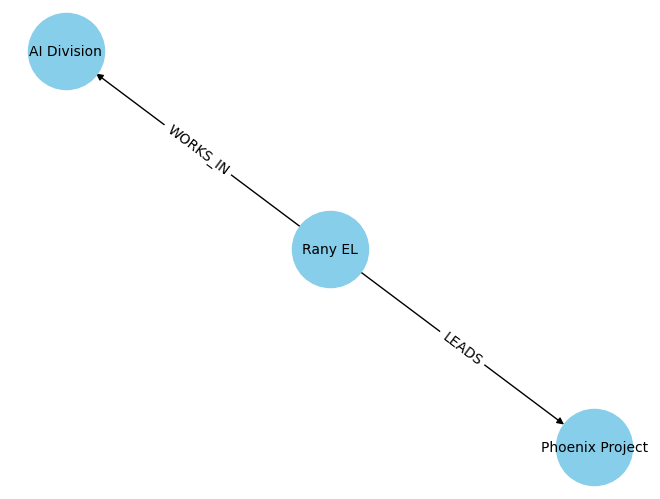

In [23]:
# You'll need to install networkx and matplotlib to visualize the graph
# pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Add nodes with properties (attributes)
G.add_node("Rany EL", type='Person', title='Senior Manager')
G.add_node("Phoenix Project", type='Project')
G.add_node("AI Division", type='Division')

# Add directed relationships (edges) between the nodes
G.add_edge("Rany EL", "Phoenix Project", label='LEADS')
G.add_edge("Rany EL", "AI Division", label='WORKS_IN')

# Now, let's do a simple visualization to see what we've built
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

## The Indexing Pipeline - Building Our Knowledge Catalog

### Installing Chromadb for Google Colab


In [24]:
import sys, subprocess
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    try:
        subprocess.run([sys.executable, '-m', 'pip', 'install', 'chromadb==0.5.5', '--quiet'], check=False)
    except Exception as e:
        print(f'WARNING: pip install failed: {e}')


### Initialize the vector store for indexing

The following code sets up the minimal infrastructure for our indexing pipeline.

- __What this does__
  - `chroma_client = chromadb.PersistentClient(path="db")`: Initializes a persistent ChromaDB client at `./db` (local disk for this demo)
  - `collection = chroma_client.get_or_create_collection(name="chapter4_collection")`: Creates or opens the `chapter4_collection` where embeddings and source text will be stored

- __Why this matters__
  - The collection acts like a vector “table” we’ll reuse throughout the notebook
  - Persistence lets you run subsequent cells without re-indexing each time

- __Notes__
  - Local persistence is convenient for learning
  - For production, prefer a managed/vector DB with proper lifecycle, observability, and access controls

In [25]:
import sys
import os

# print("=== Environment Verification ===")
# print(f"Python executable: {sys.executable}")
# print(f"Python version: {sys.version}")

# Check if we're using the shared book environment
if 'data_strategy_env' in sys.executable:
    print("SUCCESS: Using book environment (data_strategy_env)")
else:
    print("WARNING: Not using data_strategy_env")
    print("   Expected path should contain 'data_strategy_env'")

# Check current working directory
# print(f"Working directory: {os.getcwd()}")

# Verify key packages and versions
try:
    import numpy
    print(f"NumPy version: {numpy.__version__}")
    if numpy.__version__.startswith('1.'):
        print("SUCCESS: NumPy version compatible with ChromaDB")
    else:
        print("WARNING: NumPy version may cause ChromaDB issues")
except ImportError:
    print("ERROR: NumPy not installed")

try:
    import chromadb
    print("SUCCESS: ChromaDB available")
except ImportError as e:
    print(f"ERROR: ChromaDB not available: {e}")

try:
    from openai import OpenAI
    print("SUCCESS: OpenAI client available")
except Exception:
    try:
        import openai
        print("SUCCESS: OpenAI available (legacy import)")
    except ImportError:
        print("ERROR: OpenAI not available")


SUCCESS: Using book environment (data_strategy_env)
NumPy version: 1.26.4
SUCCESS: NumPy version compatible with ChromaDB
SUCCESS: ChromaDB available
SUCCESS: OpenAI client available


In [26]:
# First, make sure you have the necessary libraries installed
# pip install chromadb

import chromadb
from pathlib import Path

# --- 1. Setup ---
# Use a shared on-disk DB for Chapters 4 and 5
repo_root = Path().cwd()
while not (repo_root / 'utils').exists() and repo_root.parent != repo_root:
    repo_root = repo_root.parent
SHARED_DB = repo_root / 'data' / 'chroma_db'
SHARED_DB.mkdir(parents=True, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=str(SHARED_DB))




In [27]:


rany_demo_client = chromadb.PersistentClient(path="data/rany")


We’re setting up the embedding function that turns text into vectors so the retriever can index and search efficiently. I prefer to define this once, early, so everything downstream (collection creation, add/upsert) uses a single, consistent embedding configuration.

In [28]:
from chromadb.utils import embedding_functions 
 

ef = embedding_functions.OpenAIEmbeddingFunction( 
 api_key=os.getenv("OPENAI_API_KEY"), 
 model_name="text-embedding-3-small", 
) 

The snippet initializes `embedding_functions.OpenAIEmbeddingFunction` and assigns it to `ef`. It pulls the API key from the environment via `os.getenv("OPENAI_API_KEY")`, so there’s no hardcoded secrets, and specifies `model_name="text-embedding-3-small"` as a cost‑efficient default. Practically, `ef` is just a callable that accepts a list of strings and returns their embeddings; vector stores (e.g., when you call `create_collection(..., embedding_function=ef)`) will invoke it automatically during add/upsert.

We’re creating (or reusing) a vector collection that the indexing pipeline will write to. I keep this early in the setup so every subsequent add/upsert, query, and reindex targets a single, well-named collection without surprises.

In [29]:
# Get or create a collection. This is like a table in a traditional database.
# We can also specify the embedding model we want to use.
collection = chroma_client.get_or_create_collection(
    name="book_collection",
    embedding_function=ef
)

The call to `chroma_client.get_or_create_collection(name="book_collection", embedding_function=ef)` returns a `collection` handle. If the collection exists, it’s reused; if not, it’s created. Passing `embedding_function=ef` ensures consistent embeddings during ingestion so you don’t accidentally mix models across runs.

### Results and verification

After running the above code:

- __Expected results__
  - ChromaDB client connected to local database
  - Collection handle ready for document operations

- __Verify the results__
  

In [30]:
# Check if database directory was created
import os
from pathlib import Path
repo_root = Path().cwd()
while not (repo_root / 'utils').exists() and repo_root.parent != repo_root:
    repo_root = repo_root.parent
SHARED_DB = repo_root / 'data' / 'chroma_db'
print(f"Database directory exists: {SHARED_DB.exists()}")

# Verify collection was created
print(f"Collection count: {collection.count()}")
print(f"Collection name: {collection.name}")


Database directory exists: True
Collection count: 11
Collection name: book_collection


We’re adding a single sentence to the collection to verify the indexing path end to end. I like doing this quick sanity check before batch ingestion so we know the collection accepts new items and the embedding function is wired correctly.

In [31]:
collection.add(documents=["This is a quick test sentence to index."], ids=["manual_1"])

Add of existing embedding ID: manual_1
Insert of existing embedding ID: manual_1


Calling `collection.add(documents=["This is a quick test sentence to index."], ids=["manual_1"])` inserts one record with a unique ID. Because we passed `embedding_function=ef` when creating the collection, Chroma embeds the text automatically (unless you supply `embeddings=` yourself). Keep IDs unique and stable, and ensure the collection’s embedding dimensionality matches the model you’re using.

This helper gives us a tiny “VectorIndexer” we can call anywhere: hand it a list of texts and it will generate stable IDs, skip what’s already in the collection, and write the rest in small batches. I like this pattern because it’s safe to re-run and it keeps the ingestion logic in one place.

In [32]:
import hashlib
from typing import Iterable, List, Optional, Dict, Any

def vector_indexer(
    collection,
    texts: Iterable[str],
    id_prefix: str = "txt",
    metadatas: Optional[List[Dict[str, Any]]] = None,
    batch_size: int = 128,
) -> List[str]:
    """
    Minimal indexing helper.
    Assumes the collection was created with embedding_function=... so embeddings are computed automatically.
    Uses content-hash IDs for idempotency: same text -> same ID.
    """
    texts = list(texts)
    ids = [f"{id_prefix}_{hashlib.sha1(t.encode('utf-8')).hexdigest()[:16]}" for t in texts]

    # Skip documents that already exist (best-effort)
    try:
        existing = set(collection.get(ids=ids)["ids"])
    except Exception:
        existing = set()

    pending_docs, pending_ids, pending_metas = [], [], []
    written = []

    for i, (t, _id) in enumerate(zip(texts, ids)):
        if _id in existing:
            continue
        pending_docs.append(t)
        pending_ids.append(_id)
        if metadatas:
            pending_metas.append(metadatas[i])
        if len(pending_docs) >= batch_size:
            collection.add(
                documents=pending_docs,
                ids=pending_ids,
                metadatas=pending_metas if metadatas else None,
            )
            written.extend(pending_ids)
            pending_docs, pending_ids, pending_metas = [], [], []

    if pending_ids:
        collection.add(
            documents=pending_docs,
            ids=pending_ids,
            metadatas=pending_metas if metadatas else None,
        )
        written.extend(pending_ids)

    return written

The function builds deterministic IDs using a SHA‑1 hash of each text (`hashlib.sha1(...).hexdigest()[:16]`) with an `id_prefix`, then does a best‑effort lookup via `collection.get(ids=ids)` to avoid duplicates. It stages documents in memory and flushes them in batches to `collection.add(documents=..., ids=..., metadatas=...)`, extending the `written` list each time. If the collection was created with `embedding_function=...`, Chroma computes embeddings automatically on add; otherwise you would pass `embeddings=` explicitly. The return value is the list of IDs that were actually written this run.

In [33]:
# After creating the collection with embedding_function=ef
ids = vector_indexer(collection, ["First line", "Second line"], id_prefix="demo")
print(f"Indexed {len(ids)} items")

Indexed 0 items


In [34]:
# --- 2. Our Raw Data --- 
# In a real system, this would come from files, a database, or an API.
# For our example, we'll just use a list of strings.
documents = [
    "The company's new AI policy, effective June 1st, requires all employees to complete a mandatory training course.",
    "Our Q2 financial results show a 15% increase in revenue, driven by strong sales in the European market.",
    "The Phoenix Project, our next-generation AI platform, is scheduled for a beta release in the third quarter.",
    "All travel and expense reports must be submitted through the new online portal by the 25th of each month."
]

We’re switching from a manual for‑loop to a tiny VectorIndexer call so the ingestion path is one line: give it the list of documents and it will generate stable IDs, skip anything already present, and write the rest. I like this pattern because it’s safe to re-run and it keeps the “how to index” logic in one place instead of scattering it across the notebook.

In [35]:
# --- 3. The Indexing Process (using vector_indexer) ---
# This will generate stable IDs, skip existing items, and add the rest in batches.
written_ids = vector_indexer(
    collection=collection,
    texts=documents,
    id_prefix="doc"  # so IDs look like doc_<hash>
)

print(f"Indexed {len(written_ids)} new items: {written_ids}")

Indexed 0 new items: []


The call to `vector_indexer(collection=collection, texts=documents, id_prefix="doc")` computes deterministic IDs from each text (content hash with a prefix), does a best‑effort lookup via `collection.get(ids=...)` to avoid duplicates, and batches writes through `collection.add(...)`. Because the collection was created with `embedding_function=...`, embeddings are computed automatically on add. The function returns `written_ids`, the IDs actually inserted in this run, which we print to confirm what was indexed.

In [36]:
# --- 4. Verification ---
# Let's check how many items are in our collection.

count = collection.count()
print(f"\nThe collection now contains {count} items.")


The collection now contains 11 items.


The following example adds the same documents manually. I kept it just for showing the difference. We will be using vector_indexer() in the future.

In [37]:
# --- 2. Our Raw Data --- 
# In a real system, this would come from files, a database, or an API.
# For our example, we'll just use a list of strings.
documents = [
    "The company's new AI policy, effective June 1st, requires all employees to complete a mandatory training course.",
    "Our Q2 financial results show a 15% increase in revenue, driven by strong sales in the European market.",
    "The Phoenix Project, our next-generation AI platform, is scheduled for a beta release in the third quarter.",
    "All travel and expense reports must be submitted through the new online portal by the 25th of each month."
]

# --- 3. The Indexing Process --- 
# We need to add each document to our collection. ChromaDB will handle
# the embedding process for us automatically if we don't provide our own.
# We also need to provide a unique ID for each document.

# It's good practice to check if the document already exists before adding.
existing_ids = collection.get(ids=[f"id_{i}" for i in range(len(documents))])['ids']

for i, doc in enumerate(documents):
    # Create a predictable ID for this document (id_0, id_1, etc.)
    doc_id = f"id_{i}"
    
    # Only add the document if it's not already in the collection
    if doc_id not in existing_ids:
        collection.add(
            documents=[doc],  # The actual text content
            ids=[doc_id]      # Our unique identifier
        )
        print(f"Added document {doc_id} to the collection.")
    else:
        print(f"Document {doc_id} already exists in the collection.")

# --- 4. Verification --- 
# Let's check how many items are in our collection.
count = collection.count()
print(f"\nThe collection now contains {count} items.")

Document id_0 already exists in the collection.
Document id_1 already exists in the collection.
Document id_2 already exists in the collection.
Document id_3 already exists in the collection.

The collection now contains 11 items.


In [38]:
# Let's also peek at what's actually stored
all_data = collection.get()
print(f"Document IDs: {all_data['ids']}")
print(f"A document preview: {all_data['documents'][3][:50]}...")

Document IDs: ['demo_b456a020d1eecda5', 'demo_ce405c63b181a6ab', 'doc_3881aea93a79aa81', 'doc_4c1db3c165dd788a', 'doc_7da6c838a91b28c5', 'doc_e703d12f46044bda', 'id_0', 'id_1', 'id_2', 'id_3', 'manual_1']
A document preview: The Phoenix Project, our next-generation AI platfo...


## Minimal Assistant Class (for testing)

This simple class satisfies structural tests without affecting chapter scope.

In [39]:
class BasicAIAssistant:
    def __init__(self, model_name: str = 'text-embedding-3-small'):
        self.model_name = model_name
    def answer(self, prompt: str) -> str:
        return f'Assistant ready with model: {self.model_name}. Prompt length: {len(prompt)}'
